# Classifying host colonization range of Salmonella strains

For this project, I'll build a GEM-based (Genome-scale model) host range classifier for Salmonella strains. The data used corresponds to the paper published by Seif et al., 2020. (doi: https://doi.org/10.1038/s41467-018-06112-5)

In [63]:
import pandas as pd
import numpy as np
from itertools import product

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.metrics import roc_auc_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data loading, EDA and cleaning

In [2]:
strain_data = pd.read_csv('preprocessed_data/pre-processed_strain_profiles.csv', index_col=0)
strain_data.head()

,strain_id,c_decanoate_(n-c10:0)_(O2+),c_ethanol_(O2+),c_sucrose_(O2+),c_ornithine_(O2+),c_adenine_(O2+),n_4-aminobutanoate_(O2+),p_imp_(O2+),p_sn-glycero-3-phospho-1-inositol_(O2+),p_alpha-d-ribose_5-phosphate_(O2+),...,c_dgmp_(O2-),"c_l-alanine-d-glutamate-meso-2,6-diaminoheptanedioate-d-alanine_(O2-)",c_n-acetylneuraminate_(O2-),s_tetrathionate_(O2-),c_amp_(O2-),n_cmp_(O2-),c_d-xylose_(O2-),n_d-glucosamine_6-phosphate_(O2-),c_udp-n-acetyl-d-galactosamine_(O2-),host_range
0,CP007292,0.48724,0.417504,0.0,0.607608,0.0,0.809491,1.194922,1.031570,0.974285,...,0.213765,0.12474,0.307988,0.211764,0.274616,0.288371,0.127108,0.427014,0.098308,Broad
1,877468.3,0.48745,0.418011,0.0,0.607634,0.0,0.809491,1.195404,1.031967,0.974661,...,0.213765,0.12474,0.307988,0.211846,0.274616,0.288371,0.127108,0.427014,0.098308,Broad
2,1412469.3,0.48724,0.417504,0.0,0.607608,0.0,0.809491,1.194922,1.031570,0.974285,...,0.213765,0.12474,0.307988,0.211764,0.274616,0.288371,0.127108,0.427014,0.098308,Broad
3,1454603.3,0.48745,0.418011,0.0,0.607608,0.0,0.809491,1.195404,1.031967,0.974661,...,0.213765,0.12474,0.307988,0.211846,0.274616,0.288371,0.127108,0.427014,0.098308,Broad
4,54388.42,0.48745,0.418011,0.0,0.607634,0.0,0.809491,1.190090,1.031967,0.974661,...,0.212696,0.12474,0.307988,0.211846,0.274009,0.288371,0.127108,0.427014,0.000000,Restricted (Human)


In [3]:
numerical = strain_data.columns.to_list()
numerical.remove('strain_id')
numerical.remove('host_range')

strain_data[numerical] = strain_data[numerical].clip(lower=0)

In [4]:
strain_data.describe()

,c_decanoate_(n-c10:0)_(O2+),c_ethanol_(O2+),c_sucrose_(O2+),c_ornithine_(O2+),c_adenine_(O2+),n_4-aminobutanoate_(O2+),p_imp_(O2+),p_sn-glycero-3-phospho-1-inositol_(O2+),p_alpha-d-ribose_5-phosphate_(O2+),c_trimethylamine_n-oxide_(O2+),...,p_ump_(O2-),c_dgmp_(O2-),"c_l-alanine-d-glutamate-meso-2,6-diaminoheptanedioate-d-alanine_(O2-)",c_n-acetylneuraminate_(O2-),s_tetrathionate_(O2-),c_amp_(O2-),n_cmp_(O2-),c_d-xylose_(O2-),n_d-glucosamine_6-phosphate_(O2-),c_udp-n-acetyl-d-galactosamine_(O2-)
count,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,...,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000
mean,0.480662,0.412185,0.003201,0.599168,0.000175,0.799750,1.183390,1.069438,0.963047,0.000420,...,0.258852,0.212773,0.122691,0.304833,0.211826,0.273170,0.285991,0.124095,0.423892,0.096506
std,0.057609,0.049063,0.064745,0.071497,0.003197,0.085177,0.110524,0.139735,0.102640,0.006107,...,0.036731,0.019936,0.016240,0.034446,0.035464,0.025226,0.025382,0.021888,0.036623,0.016437
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.487240,0.417504,0.000000,0.607608,0.000000,0.809491,1.194922,1.031570,0.974285,0.000000,...,0.260176,0.213765,0.124740,0.307988,0.211764,0.274616,0.288371,0.127108,0.427014,0.098308
50%,0.487450,0.418011,0.000000,0.607634,0.000000,0.809491,1.195404,1.031967,0.974661,0.000000,...,0.260176,0.213765,0.124740,0.307988,0.211846,0.274616,0.288371,0.127108,0.427014,0.098308
75%,0.487450,0.418011,0.000000,0.607634,0.000000,0.809491,1.195404,1.045123,0.974661,0.000000,...,0.260176,0.213765,0.124740,0.307988,0.211846,0.274616,0.288371,0.127108,0.427014,0.098308
max,0.507991,0.430555,1.309382,0.635798,0.064252,0.852844,1.877534,1.669622,1.587836,0.101851,...,0.830435,0.394950,0.249128,0.461198,0.838478,0.458938,0.302769,0.272202,0.446970,0.251855


##### It seems that the data contains features with low variance across strains (rows). I'll take this observation into consideration for downstream feature engineering steps.

##### Now let's look at the distribution of the target variable 'host_range'

In [5]:
strain_data.host_range.value_counts()

host_range
Broad                        339
Restricted (Human)            52
Restricted (Avian)             7
Restricted (Cold-blooded)      6
Restricted (Bovine)            3
Restricted (Swine)             2
Name: count, dtype: int64

##### Since I'm intersted in classifying strains as either Generalists (Broad) or Specialists (Restricted). I'll encode the target variable such that the 'Broad' class is represented as 1 and all other variations of 'Restricted' as 0. This turns the problem into a binary classification one.

In [6]:
encoded = (strain_data.host_range == 'Broad').astype(int)
encoded.name = 'host_range_encoded'
strain_data = pd.concat([strain_data, encoded], axis=1)

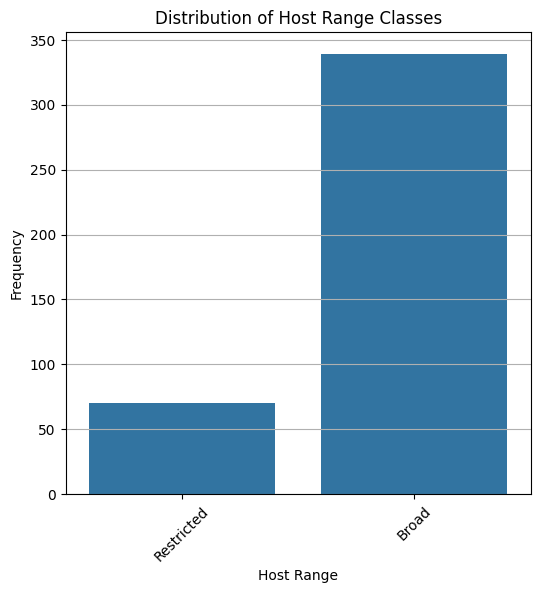

In [7]:
target_distribution = strain_data['host_range_encoded'].value_counts()

plt.figure(figsize=(6, 6))
sns.barplot(x=target_distribution.index, y=target_distribution.values,)
plt.title('Distribution of Host Range Classes')
plt.xlabel('Host Range')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Renaming x-axis labels
plt.xticks([0, 1], ['Restricted', 'Broad'])

plt.show()

After encoding the variable, we can see that the host range class is imbalanced, having a higher number of strains classified as "Broad". This observation will be taken in consideration for building the model and the evaluation metrics used.

Now we will plot the flux distribution across all strains for the two classes:

In [8]:
# Convert data to tidy format
tidy_df = pd.melt(strain_data, ['host_range','host_range_encoded','strain_id'], var_name='nutrient',value_name='flux')
tidy_df.head()

,host_range,host_range_encoded,strain_id,nutrient,flux
0,Broad,1,CP007292,c_decanoate_(n-c10:0)_(O2+),0.48724
1,Broad,1,877468.3,c_decanoate_(n-c10:0)_(O2+),0.48745
2,Broad,1,1412469.3,c_decanoate_(n-c10:0)_(O2+),0.48724
3,Broad,1,1454603.3,c_decanoate_(n-c10:0)_(O2+),0.48745
4,Restricted (Human),0,54388.42,c_decanoate_(n-c10:0)_(O2+),0.48745


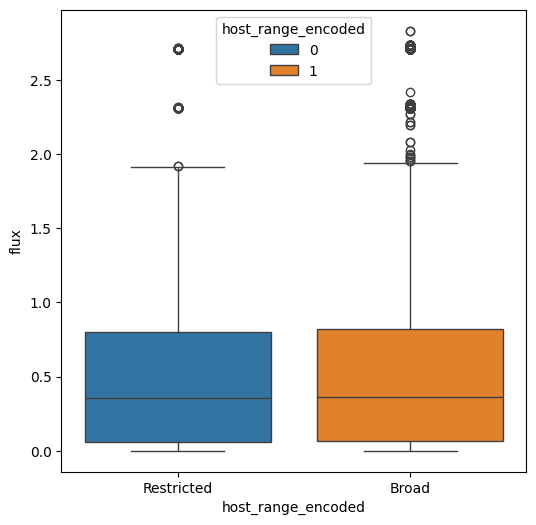

In [9]:
plt.figure(figsize=(6, 6))
sns.boxplot(tidy_df, x='host_range_encoded' ,y='flux', hue='host_range_encoded')
plt.xticks([0, 1], ['Restricted', 'Broad'])
plt.show()

## 2. Feature importance and selection

In [68]:
df_train, df_test = train_test_split(strain_data, test_size=0.2, random_state=11)
y_train = df_train['host_range_encoded'].values
y_test = df_test['host_range_encoded'].values

#### Function for calculating mutual information

In [11]:
def calculate_mutual_information(df, features, target_variable='host_range_encoded'):
    X = df[features]
    y = df[target_variable]

    mutual_info = mutual_info_classif(X,y)
    mi_df = pd.DataFrame({'feature': X.columns, 'mutual_information': mutual_info})
    mi_df.sort_values(by='mutual_information', ascending=False, inplace=True)
    return mi_df

#### Function for filtering features based on selected method and threshold

In [12]:
def filter_and_select_features(df,numerical_features,method = 'variance',target_variable='host_range_encoded',threshold=0.01):
    if method == 'variance':
        features_dict = df[numerical_features].to_dict(orient='records')
        selector = VarianceThreshold(threshold=threshold)

        dv = DictVectorizer(sparse=False)
        features_vectorized = dv.fit_transform(features_dict)
        feature_names = dv.get_feature_names_out()

        features_filtered = selector.fit_transform(features_vectorized)
        support_array = selector.get_support()
        selected_features = feature_names[support_array].tolist()
    
    elif method == 'mutual_information':
        mi_df = calculate_mutual_information(df,numerical_features,target_variable=target_variable)
        selected_features = mi_df[mi_df.mutual_information > threshold].feature.to_list()
    return selected_features

### Filtering features by variance

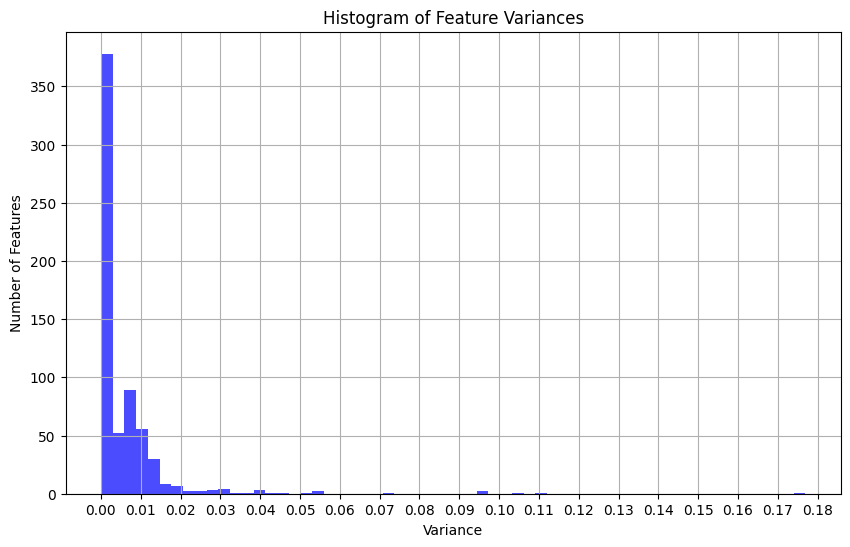

In [13]:
feature_variances = df_train[numerical].var()

# Plotting the histogram of variances
plt.figure(figsize=(10, 6))
plt.hist(feature_variances, bins=60, color='blue', alpha=0.7)
plt.title('Histogram of Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Number of Features')

plt.xticks(np.arange(0, feature_variances.max() + 0.01, 0.01))

plt.grid(True)
plt.show()

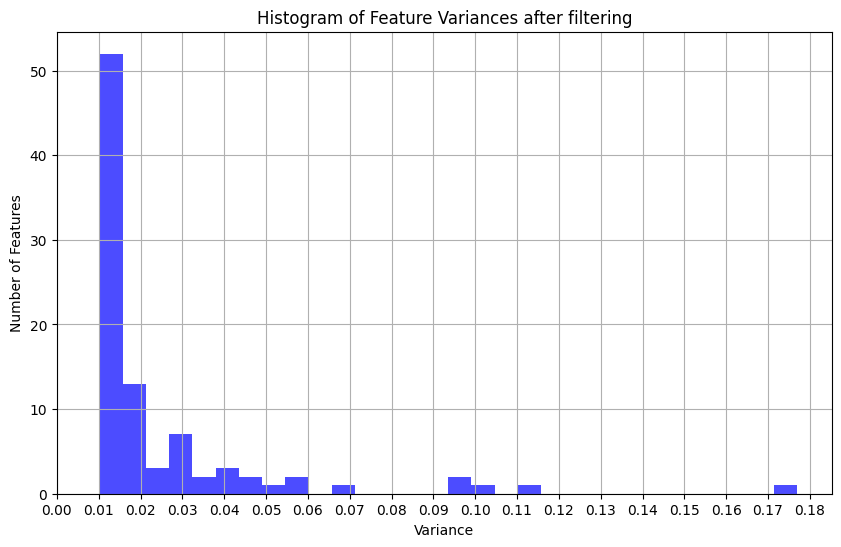

In [14]:
selected_features = filter_and_select_features(df_train, numerical_features=numerical,method='variance',threshold=0.01)
feature_variances = df_train[selected_features].var()

# Plotting the histogram of variances
plt.figure(figsize=(10, 6))
plt.hist(feature_variances, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Feature Variances after filtering')
plt.xlabel('Variance')
plt.ylabel('Number of Features')

plt.xticks(np.arange(0, feature_variances.max() + 0.01, 0.01))

plt.grid(True)
plt.show()

### Calculating mutual information

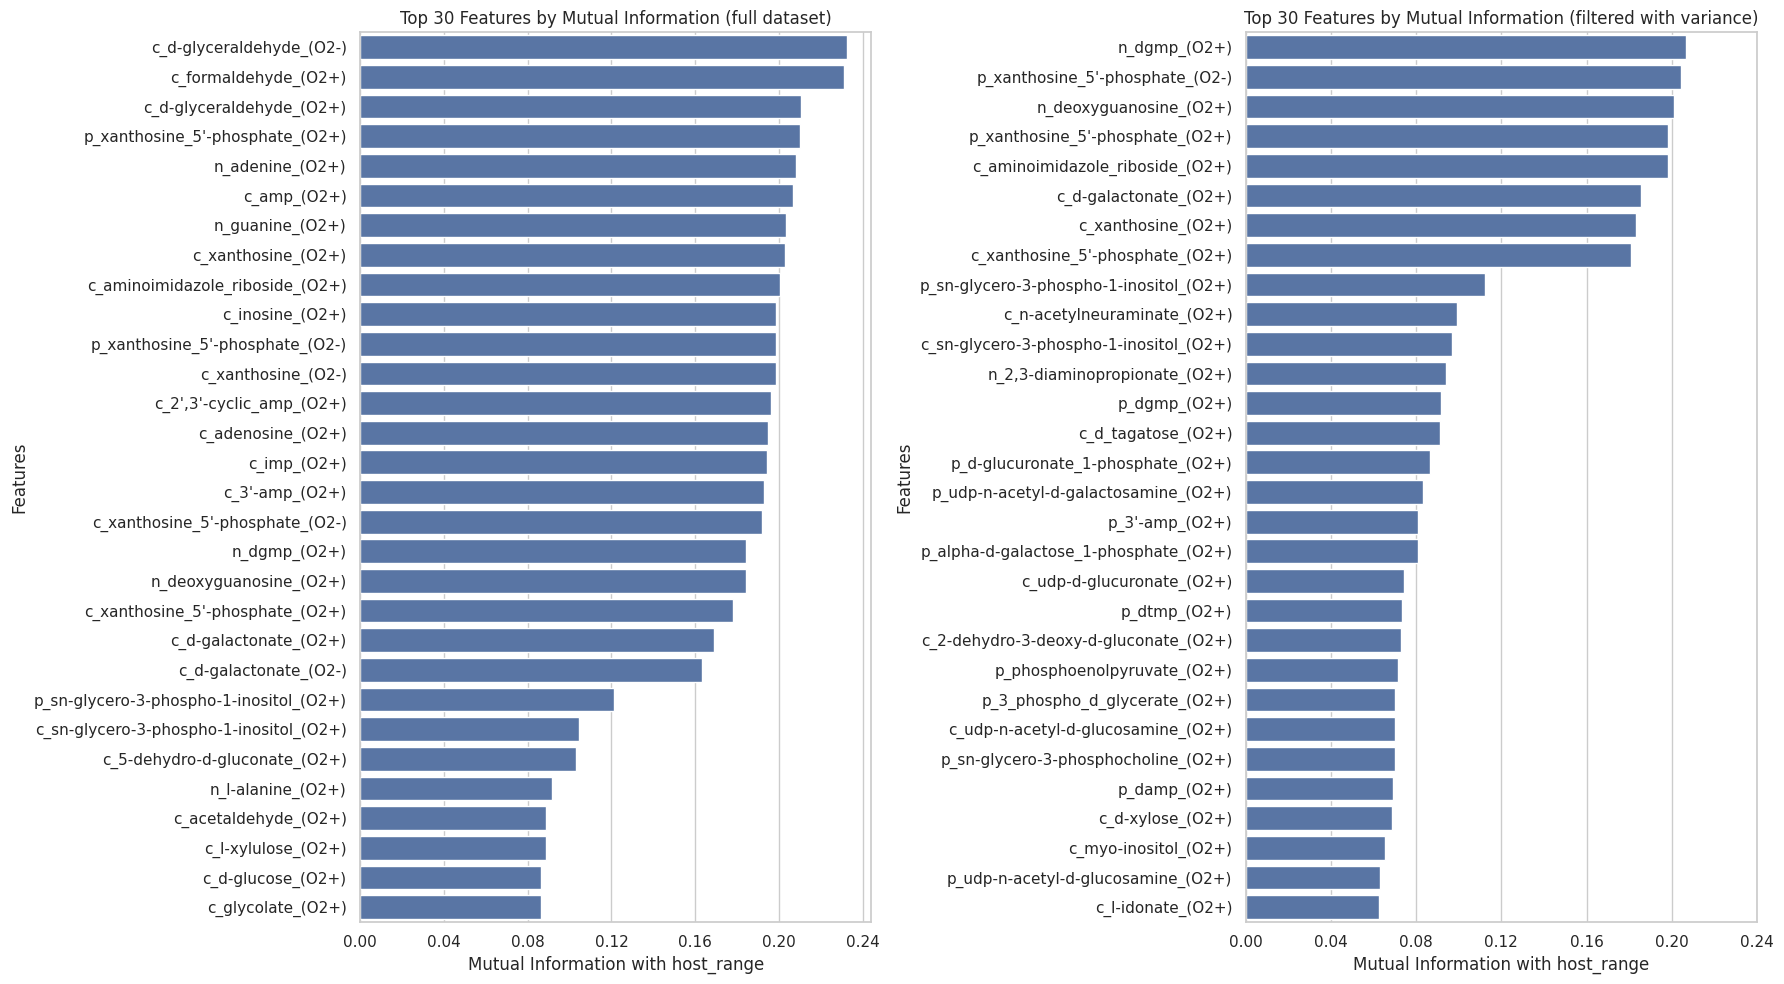

In [15]:
# Calculate mutual information score
mi_variance_filtered = calculate_mutual_information(df_train,selected_features)
mi_complete = calculate_mutual_information(df_train,numerical)

sns.set(style="whitegrid")
num_features = 30

# Data for the subplots
top_mi_features_1 = mi_complete.head(num_features)
top_mi_features_2 = mi_variance_filtered.head(num_features)

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))  # Adjust nrows and ncols as needed

# First subplot
sns.barplot(x="mutual_information", y="feature", data=top_mi_features_1, ax=axes[0])
axes[0].set_title(f'Top {num_features} Features by Mutual Information (full dataset)')
axes[0].set_xlabel('Mutual Information with host_range')
axes[0].set_ylabel('Features')
axes[0].set_xticks(np.arange(0, top_mi_features_1['mutual_information'].max() + 0.04, 0.04))

# Second subplot
sns.barplot(x="mutual_information", y="feature", data=top_mi_features_2, ax=axes[1])
axes[1].set_title(f'Top {num_features} Features by Mutual Information (filtered with variance)')
axes[1].set_xlabel('Mutual Information with host_range')
axes[1].set_ylabel('Features')
axes[1].set_xticks(np.arange(0, top_mi_features_2['mutual_information'].max() + 0.04, 0.04))

# Adjust layout
plt.tight_layout()
plt.show()

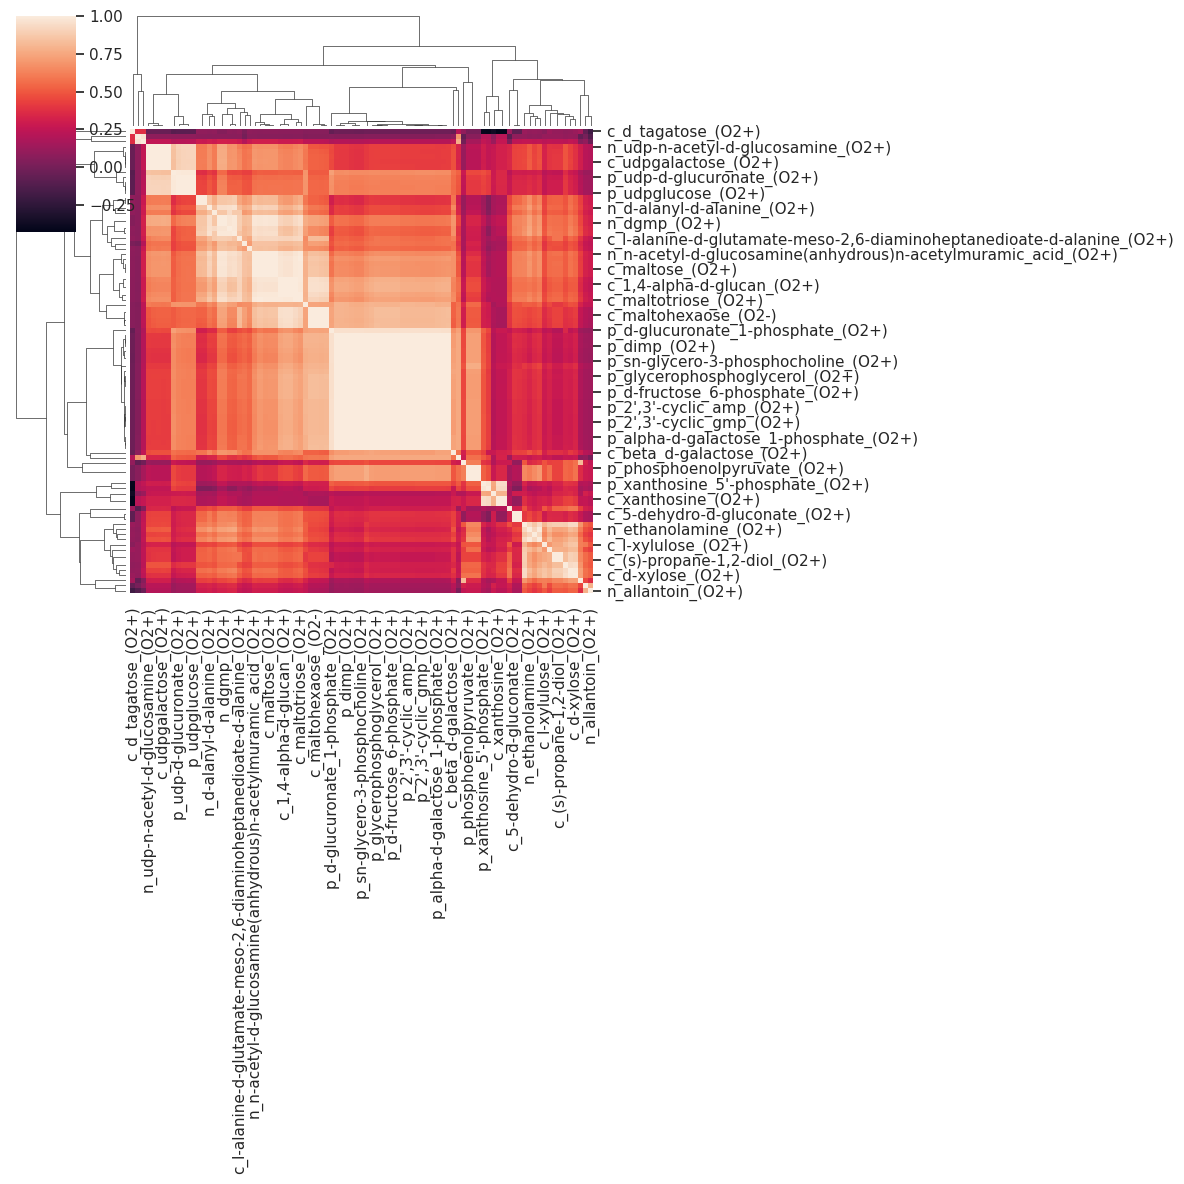

In [16]:
sns.clustermap(df_train[selected_features].corr(), figsize=(12,12))

<Figure size 1200x1200 with 0 Axes>

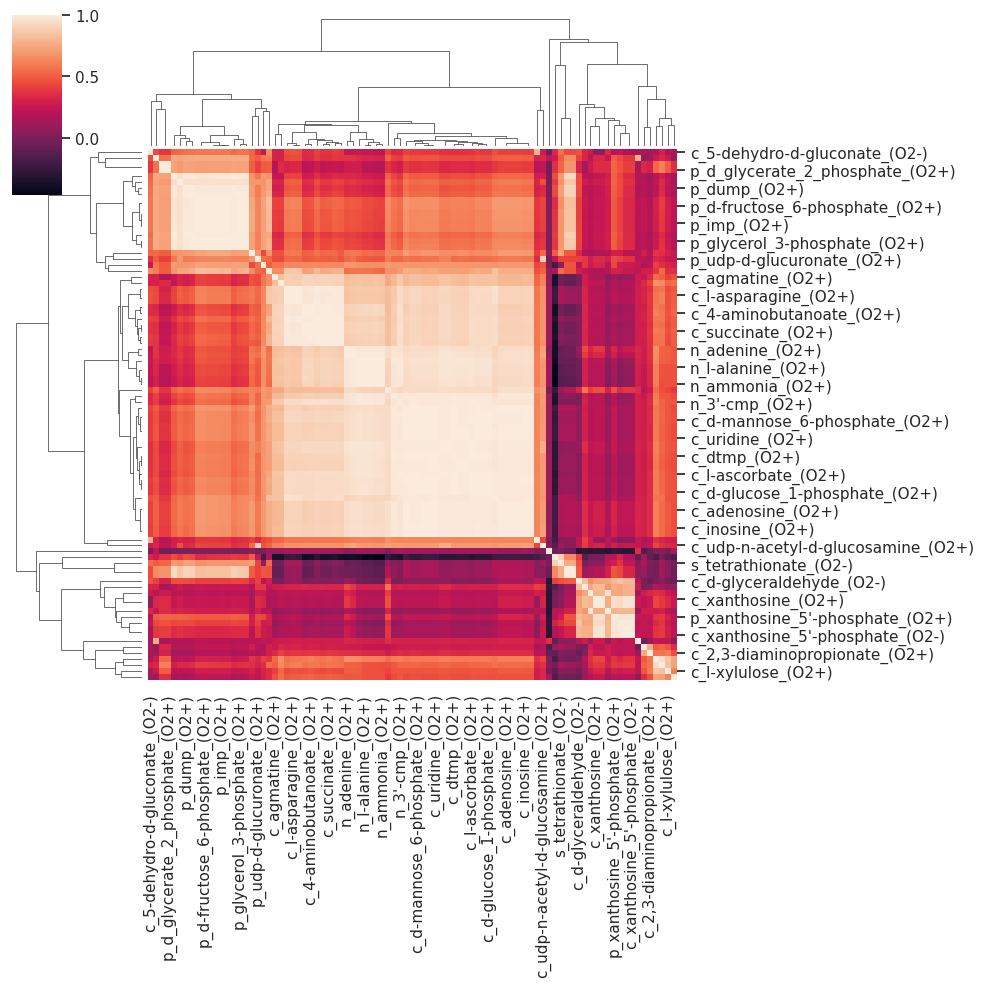

In [17]:
plt.figure(figsize=(12,12))
sns.clustermap(df_train[mi_complete.head(89).feature.to_list()].corr())

## 3. Training Models

In [18]:
def get_vectorized_training_data(df,features):
    data_dicts=df[features].to_dict(orient='records')
    dv=DictVectorizer(sparse=False)
    X_vect=dv.fit_transform(data_dicts)
    return dv, X_vect

### 3.1 Hyperparameter tuning and cross-validation

In [50]:
def hyperparameter_tuning_cv(df_train, y_train, numerical_features, model_type, param_grid, folds=5, metric=roc_auc_score, selection_threshold=0.01, rand_state=11):

    kf = KFold(n_splits=folds, shuffle=True, random_state=rand_state)

    best_score = -np.inf
    best_params = None

    # Generate all combinations of parameters
    param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

    for params in param_combinations:
        fold_scores = []

        for train_index, val_index in kf.split(df_train):
            # Split data
            df_train_fold, df_val_fold = df_train.iloc[train_index][numerical_features], df_train.iloc[val_index][numerical_features]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Select features based on variance threshold
            selected_features = filter_and_select_features(df_train_fold, numerical_features, threshold=selection_threshold)

            dv, X_train_fold = get_vectorized_training_data(df_train_fold, selected_features)

            val_dicts = df_val_fold[selected_features].to_dict(orient='records')
            X_val_fold = dv.transform(val_dicts)

            # Instantiate the model based on model type
            if model_type == 'decision_tree':
                model = DecisionTreeClassifier(**params, random_state=rand_state)
            elif model_type == 'random_forest':
                model = RandomForestClassifier(**params, random_state=rand_state)
            elif model_type == 'logistic_regression':
                model = LogisticRegression(**params, random_state=rand_state, max_iter=1000)
            else:
                raise ValueError("Invalid model type. Choose 'decision_tree', 'random_forest', or 'logistic_regression'.")

            # Train the model
            model.fit(X_train_fold, y_train_fold)

            # Evaluate the model
            y_pred = model.predict_proba(X_val_fold)[:, 1] if model_type == 'logistic_regression' else model.predict(X_val_fold)
            score = metric(y_val_fold, y_pred)
            fold_scores.append(score)

        # Average score across folds for the current set of parameters
        avg_score = np.mean(fold_scores)
        stdev_score = np.std(fold_scores)

        if avg_score > best_score:
            best_score = avg_score
            best_params = params

    return best_score, stdev_score, best_params

#### Logistic regression

In [52]:
param_grid
best_score,std_score,best_params = hyperparameter_tuning_cv(df_train, y_train, numerical_features=numerical, param_grid=param_grid ,model_type='logistic_regression')
print(f'Best auc score: {best_score}, std_score: {std_score}, Best parameters: {best_params}')

Best auc score: 0.896330098369314, std_score: 0.04264661612333072, Best parameters: {'C': 1}


#### Decision tree

In [55]:
param_grid = {
    'max_depth': [None, 2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4]
}
best_score,std_score,best_params = hyperparameter_tuning_cv(df_train,y_train,numerical,model_type='decision_tree',param_grid=param_grid,metric=roc_auc_score)
print(f'Best auc score: {best_score}, std_score: {std_score}, Best parameters: {best_params}')

Best auc score: 0.8650841750841751, std_score: 0.05270258214267505, Best parameters: {'max_depth': None, 'min_samples_leaf': 3}


#### Random Forest

In [56]:
param_grid = {
    'n_estimators': [10, 50, 100], 
    'max_depth': [3, 5, 10], 
    'min_samples_split': [2, 5, 10]
}
best_score,std_score,best_params = hyperparameter_tuning_cv(df_train,y_train,numerical,model_type='random_forest',param_grid=param_grid,metric=roc_auc_score)
print(f'Best auc score: {best_score}, std_score: {std_score}, Best parameters: {best_params}')

Best auc score: 0.8565656565656565, std_score: 0.04037913092984173, Best parameters: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2}


## 4. Final train and test on models

In [48]:
def train_final_model_lr(df_train, y_train, features, model_type, best_parameters, rand_state=11):
    
    dv, X_train_vect = get_vectorized_training_data(df_train, features)

    if model_type == 'decision_tree':
        model = DecisionTreeClassifier(**best_parameters, random_state=rand_state)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**best_parameters, random_state=rand_state)
    elif model_type == 'logistic_regression':
        model = LogisticRegression(**best_parameters, random_state=rand_state, max_iter=1000)
    else:
        raise ValueError("Invalid model type. Choose 'decision_tree', 'random_forest', or 'logistic_regression'.")

    model.fit(X_train_vect, y_train)
    return model, dv

In [57]:
def test_final_model(model, df_test, y_test, dv, features, threshold=0.5):
    test_dicts = df_test[features].to_dict(orient='records')
    X_test = dv.transform(test_dicts)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = Binarizer(threshold=threshold).transform([y_pred_proba])[0]

    metrics = {
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    return metrics

#### Logistic regression

In [64]:
best_params = {'C': 1}
selected_features = filter_and_select_features(df_train, numerical_features=numerical)
model, dv = train_final_model_lr(df_train, y_train, selected_features, model_type='logistic_regression', best_parameters=best_params)

test_final_model(model, df_test, y_test, dv, selected_features)

{'roc_auc': 0.9725378787878788,
 'precision': 0.9848484848484849,
 'recall': 0.9848484848484849,
 'f1_score': 0.9848484848484849}

#### Decision tree

In [73]:
best_params = {'max_depth': None, 'min_samples_leaf': 3}
selected_features = filter_and_select_features(df_train, numerical_features=numerical)
model, dv = train_final_model_lr(df_train, y_train, selected_features, model_type='decision_tree', best_parameters=best_params)

test_final_model(model, df_test, y_test, dv, selected_features)

{'roc_auc': 0.9621212121212122,
 'precision': 0.9850746268656716,
 'recall': 1.0,
 'f1_score': 0.9924812030075187}

#### Random Forest

In [75]:
best_params = {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2}
selected_features = filter_and_select_features(df_train, numerical_features=numerical)
model, dv = train_final_model_lr(df_train, y_train, selected_features, model_type='random_forest', best_parameters=best_params)

test_final_model(model, df_test, y_test, dv, selected_features)

{'roc_auc': 0.9616477272727273,
 'precision': 0.9850746268656716,
 'recall': 1.0,
 'f1_score': 0.9924812030075187}

Logistic regression presented the highest roc_auc score, however it seems exceptionally high. To avoid potential overfitting, the decision tree model is chosen since it has a bit lower score